In [21]:
import pandas as pd
from datetime import time
import csv
import pickle
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from sklearn.linear_model import LogisticRegression

In [11]:
# addition funcs
def findRegion(check):
    for region in regions:
        for regionTemp in region:
            if regionTemp == check:
                return region[4]
    return None

def alarmsToDict(alarms):
    res = {}
    for alarm in alarms:
        temp = alarm[0].split(";")
        check1 = findRegion(temp[2].replace("\"", "").replace(" ", ""))
        check2 = findRegion(temp[3].replace("\"", "").replace(" ", ""))
        if check1 is None:
            check1 = check2
        try:
            res[check1]
        except (KeyError):
            res[check1] = []
        res[check1].append(pd.to_datetime(temp[5].replace("\"", "")))
        res[check1].append(pd.to_datetime(temp[6].replace("\"", "")))
    return res

def findDate(dates, dateTemp):
    for date in dates:
        if date == dateTemp:
            return True
        if date > dateTemp:
            return False
    return False

def createAlarmsFromWeatherData(weather, alarmsDict):
    result = []
    for weatherLine in weather:
        started = False
        for data in alarmsDict[weatherLine[0]]:
            if data > (pd.Timestamp.combine(weatherLine[1], time(1, 0, 0))):
                if started:
                    result.append(1)
                else:
                    result.append(0)
                break
            started = not started
        
    return result

def findVector(vectors, dates, date):
    for i in range(len(dates)):
        if dates[i] == date:
            return vectors[i]
            
    return None
    

In [12]:
INPUT_DATA_FOLDER = "data/modified"
WEATHER_FILE = "all_weather_by_hour6.csv"
ALARMS_FILE = "alarms.csv"
REGION_FILE = "regions.csv"
DATES_FILE = "dates.pkl"
VECTOR_FILE = "word_count_vector.pkl"

with open(f"{INPUT_DATA_FOLDER}/{WEATHER_FILE}", newline='') as csvfile:
    weatherTemp = list(csv.reader(csvfile))
    
with open(f"{INPUT_DATA_FOLDER}/{ALARMS_FILE}", newline='') as csvfile:
    alarms = list(csv.reader(csvfile))[1:]
    
with open(f"{INPUT_DATA_FOLDER}/{REGION_FILE}", newline='') as csvfile:
    regions = list(csv.reader(csvfile))
    
with open(f"{INPUT_DATA_FOLDER}/{DATES_FILE}", 'rb') as datafile:
    dates = pickle.load(datafile)
    
for i in range(len(dates)):
    dates[i] = pd.to_datetime(dates[i].replace(".txt", ""), format="%d:%m:%y")
dates = sorted(dates)

with open(f"{INPUT_DATA_FOLDER}/{VECTOR_FILE}", 'rb') as datafile:
    vectors = pickle.load(datafile)

vectors = vectors.toarray()

In [13]:
alarmsDict = alarmsToDict(alarms)
for key in alarmsDict.keys():
    alarmsDict[key].sort()
    alarmsDict[key] = list(dict.fromkeys(alarmsDict[key]))

In [6]:
print(alarmsDict.keys())
print(alarmsDict['2'][:10])


dict_keys(['2', '13', '15', '6', '17', '3', '22', '19', '8', '5', '4', '11', '10', '25', '23', '16', '14', '24', '9', '20', '18', '7', '21'])
[Timestamp('2022-02-25 22:55:42'), Timestamp('2022-02-25 23:41:53'), Timestamp('2022-02-26 08:39:39'), Timestamp('2022-02-26 10:42:41'), Timestamp('2022-02-26 10:58:23'), Timestamp('2022-02-26 11:59:40'), Timestamp('2022-02-26 16:48:36'), Timestamp('2022-02-26 17:15:37'), Timestamp('2022-02-27 10:48:03'), Timestamp('2022-02-27 11:07:09')]


In [140]:
print(weatherTemp[0])
print(weatherTemp[0][50])

['city_resolvedAddress', 'day_datetime', 'day_tempmax', 'day_tempmin', 'day_temp', 'day_feelslikemax', 'day_feelslikemin', 'day_feelslike', 'day_dew', 'day_humidity', 'day_precip', 'day_precipprob', 'day_precipcover', 'day_snow', 'day_snowdepth', 'day_windgust', 'day_windspeed', 'day_winddir', 'day_pressure', 'day_cloudcover', 'day_visibility', 'day_solarradiation', 'day_solarenergy', 'day_uvindex', 'day_severerisk', 'day_sunriseEpoch', 'day_sunsetEpoch', 'day_moonphase', 'day_conditions', 'day_icon', 'hour_datetime', 'hour_temp', 'hour_feelslike', 'hour_humidity', 'hour_dew', 'hour_precip', 'hour_precipprob', 'hour_snow', 'hour_snowdepth', 'hour_windgust', 'hour_windspeed', 'hour_winddir', 'hour_pressure', 'hour_visibility', 'hour_cloudcover', 'hour_solarradiation', 'hour_solarenergy', 'hour_uvindex', 'hour_severerisk', 'hour_conditions', 'hour_icon']
hour_icon


In [14]:
weather = []
weatherDate = []
dayConditions = {}
dayIcons = {}
hourConditions = {}
hourIcons = {}
dayConditionsIndex = 28
dayIconsIndex = 29
hourConditionsIndex = 48
hourIconsIndex = 49

for x in weatherTemp[1:]:
    temp = x.copy()
    temp[0] = findRegion(temp[0].split(",")[0])
    dateTemp = pd.to_datetime(temp[1])
    if not findDate(dates, dateTemp):
        continue
    weatherDate.append([temp[0], pd.Timestamp.combine(dateTemp, pd.to_datetime(temp[30]).time())])
#     remove  time
    temp.pop(30)
    try:
        dayConditions[temp[dayConditionsIndex]]
    except (KeyError):
        dayConditions[temp[dayConditionsIndex]] = len(dayConditions) + 1
    try:
        dayIcons[temp[dayIconsIndex]]
    except (KeyError):
        dayIcons[temp[dayIconsIndex]] = len(dayIcons) + 1
    
    try:
        hourConditions[temp[hourConditionsIndex]]
    except (KeyError):
        hourConditions[temp[hourConditionsIndex]] = len(hourConditions) + 1
    try:
        hourIcons[temp[hourIconsIndex]]
    except (KeyError):
        hourIcons[temp[hourIconsIndex]] = len(hourIcons) + 1
    
    weather.append(temp.copy())


In [267]:
print(weather[15])
print(weather[15][30])
print(weatherDate[15])
print(dayConditions)
print(hourConditions)
print(dayIcons)
print(hourIcons)


['23', '2/24/2022', '4.9', '-0.1', '1.9', '4.4', '-0.1', '1.6', '-0.6', '83.4', '0', '0', '0', '0', '0', '14.4', '8.3', '47.6', '1023.2', '69.4', '12.2', '47.4', '4.4', '2', '10', '1645677881', '1645716365', '0.77', 'Partially cloudy', 'partly-cloudy-day', '4.8', '3.4', '78.06', '1.3', '0', '0', '0', '0', '11.5', '6.1', '33.8', '1024', '0.5', '97.8', '140', '0.5', '1', '10', 'Overcast', 'fog']
4.8
['23', Timestamp('2022-02-24 15:00:00')]
{'Partially cloudy': 1, 'Clear': 2, 'Overcast': 3, 'Snow, Rain, Overcast': 4, 'Snow, Overcast': 5, 'Snow, Rain, Partially cloudy': 6, 'Snow, Partially cloudy': 7}
{'Partially cloudy': 1, 'Overcast': 2, 'Clear': 3, 'Snow, Overcast': 4, 'Snow, Rain, Overcast': 5, 'Rain, Overcast': 6, 'Snow, Partially cloudy': 7}
{'partly-cloudy-day': 1, 'clear-day': 2, 'cloudy': 3, 'snow': 4, 'rain': 5}
{'partly-cloudy-night': 1, 'cloudy': 2, 'fog': 3, 'clear-night': 4, 'clear-day': 5, 'partly-cloudy-day': 6, 'snow': 7, 'rain': 8}


In [15]:
for x in weather:
    x[dayConditionsIndex] = dayConditions[x[dayConditionsIndex]]
    x[dayIconsIndex] = dayIcons[x[dayIconsIndex]]
    x[hourConditionsIndex] = hourConditions[x[hourConditionsIndex]]
    x[hourIconsIndex] = hourIcons[x[hourIconsIndex]]
    for i in range(len(x)):
        if x[i] == '':
            x[i] = 0.0
        else:
            try:
                x[i] = float(x[i])
            except (ValueError):
                continue
            

   


In [9]:
print(weather[20:30])



[[23.0, '2/24/2022', 4.9, -0.1, 1.9, 4.4, -0.1, 1.6, -0.6, 83.4, 0.0, 0.0, 0.0, 0.0, 0.0, 14.4, 8.3, 47.6, 1023.2, 69.4, 12.2, 47.4, 4.4, 2.0, 10.0, 1645677881.0, 1645716365.0, 0.77, 1.0, 1.0, 1.2, 1.2, 94.4, 0.4, 0.0, 0.0, 0.0, 0.0, 2.2, 3.2, 54.5, 1024.0, 24.1, 14.6, 0.0, 0.0, 0.0, 10.0, 3.0, 4.0], [23.0, '2/24/2022', 4.9, -0.1, 1.9, 4.4, -0.1, 1.6, -0.6, 83.4, 0.0, 0.0, 0.0, 0.0, 0.0, 14.4, 8.3, 47.6, 1023.2, 69.4, 12.2, 47.4, 4.4, 2.0, 10.0, 1645677881.0, 1645716365.0, 0.77, 1.0, 1.0, 0.5, 0.5, 95.75, -0.1, 0.0, 0.0, 0.0, 0.0, 7.6, 4.7, 69.2, 1024.0, 24.1, 33.5, 0.0, 0.0, 0.0, 10.0, 1.0, 1.0], [23.0, '2/24/2022', 4.9, -0.1, 1.9, 4.4, -0.1, 1.6, -0.6, 83.4, 0.0, 0.0, 0.0, 0.0, 0.0, 14.4, 8.3, 47.6, 1023.2, 69.4, 12.2, 47.4, 4.4, 2.0, 10.0, 1645677881.0, 1645716365.0, 0.77, 1.0, 1.0, 0.3, 0.3, 93.67, -0.6, 0.0, 0.0, 0.0, 0.0, 7.9, 4.3, 81.7, 1024.0, 24.1, 28.4, 0.0, 0.0, 0.0, 10.0, 1.0, 1.0], [23.0, '2/24/2022', 4.9, -0.1, 1.9, 4.4, -0.1, 1.6, -0.6, 83.4, 0.0, 0.0, 0.0, 0.0, 0.0, 14.

In [16]:
# combine weather and vector (isw)
weather_vector = list()
for i in range(len(weather)):
    date = weather[i][1]
#     remove date
    weather[i].pop(1)
    weather_vector.append(list())
    weather_vector[i].extend(weather[i])
    vectorTemp = findVector(vectors, dates, pd.to_datetime(date))
    if vectorTemp is None:
        print(date)
        continue
    weather_vector[i].extend(vectorTemp)


In [270]:
print(weather_vector[400])

[23.0, 3.3, -8.6, -2.6, 0.0, -12.2, -5.8, -9.6, 60.1, 0.0, 0.0, 0.0, 0.4, 0.9, 25.2, 14.8, 312.3, 1027.3, 44.1, 21.3, 177.5, 15.5, 5.0, 10.0, 1647058322.0, 1647100313.0, 0.31, 1.0, 4.0, 3.1, -0.2, 39.09, -9.5, 0.0, 0.0, 0.0, 0.4, 23.8, 12.6, 316.2, 1024.0, 24.1, 100.0, 322.0, 1.2, 3.0, 10.0, 2.0, 2.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [17]:
alarmsBit = createAlarmsFromWeatherData(weatherDate, alarmsDict)

In [12]:
print(len(weather))
print(len(alarmsBit))
print(alarmsBit[500:600])

4999
4999
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(weather, alarmsBit, test_size=0.20, shuffle=True)
                                                    

log_reg_model = LogisticRegression(max_iter=2500000)

# Train (fit) the model
log_reg_model.fit(X_train, y_train)
# Save model
with open(f"models/model_1.pkl", "wb") as handle:
        pickle.dump(log_reg_model, handle)
# Make predictions
y_pred = log_reg_model.predict(X_test) # Predictions
y_true = y_test # True values

# Model evaluation


print("Accuracy:", np.round(accuracy_score(y_true, y_pred), 2))
precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred,
                                                               average='binary')

Accuracy: 0.78


In [28]:
# import the metrics class


cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[  0, 224],
       [  0, 776]])

Text(0.5, 427.9555555555555, 'Predicted label')

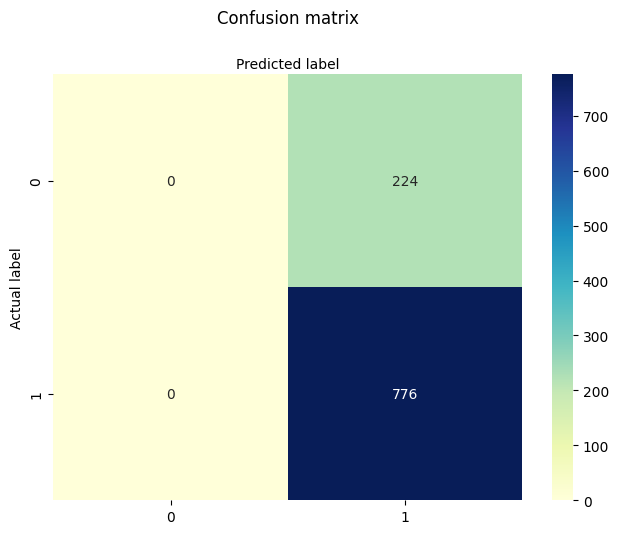

In [27]:


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

